In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  confusion_matrix
from bs4 import BeautifulSoup
from google.colab import drive
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive/', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/dataset/movie.csv')
df = pd.DataFrame(df)
df.head(1000)

Mounted at /content/drive/


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
995,"Oh, this is so bad, it is funny. The only way ...",0
996,I couldn't believe this terrible movie was act...,0
997,Even though i am slightly older than the recom...,1
998,Reading web sites on Bette Davis one can find ...,1


## Data preprocessing

In [ ]:
df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.isnull()

,text,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
39995,False,False
39996,False,False
39997,False,False
39998,False,False


In [ ]:
# df.rename(columns={'reviews': 'text', "sentiment": 'label'}, inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(40000, 2)

In [ ]:
df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [ ]:
df.columns

Index(['text', 'label'], dtype='object')

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
ps=nltk.porter.PorterStemmer()
lemmatizer = WordNetLemmatizer()
def cleanText(text):
    text = text.lower() # to lower the sentences
    text = re.sub(r'[^\w\s]', '', text) # removing punctuation marks
    text = re.sub(r'\d+', '', text) # removing numbers
    text = re.sub('\[[^]]*\]', '', text) #removing brackets
    text = re.sub('\[^A-Za-z]\]', '', text) #removing special chracters
    text = BeautifulSoup(text, "html.parser") #removing html tags
    return text.get_text()


def preprocessData(text):
    tokens = word_tokenize(text) # tokenization
    tokens = [word for word in tokens if word not in stop_words] # remove the  stopping words
    stemmed = [lemmatizer.lemmatize(word) for word in tokens] #lemmatization/stemming
    text = ' '.join(stemmed) # join clear text
    return text



In [ ]:
def dataPreparation(text):
  text = cleanText(text)
  text = preprocessData(text)
  return text

df['Cleaned_Review'] = df['text'].apply(dataPreparation)

In [ ]:
df['text'][1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

In [ ]:
df['Cleaned_Review'][1]

'put movie dvd player sat coke chip expectation hoping movie would contain strongpoints first movie awsome animation good flowing story excellent voice cast funny comedy kickass soundtrack disappointment found atlantis milo return read review first might let following paragraph directed seen first movie enjoyed primarily point mentionedbr br first scene appears shock picked atlantis milo return displaycase local videoshop whatever expectation music feel bad imitation first movie voice cast replaced fitting one exception character like voice sweet actual drawing isnt bad animation particular sad sight storyline also pretty weak like three episode schoobydoo single adventurous story got last time dont misunderstand good schoobydoo episode didnt laugh single time although might sniggered twicebr br audience havent seen first movie dont especially care similar sequel fast review movie standalone product liked schoobydoo might like movie didnt could still enjoy movie nothing else suspect mi

## Feature Extraction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Review'], df['label'], test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1), min_df=1)
tfidf_vectorizer.fit(X_train)
X_train= tfidf_vectorizer.transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

<32000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2632122 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_vectorizer.get_feature_names_out()[:10]

array(['aaron', 'abandoned', 'abc', 'ability', 'able', 'aboutbr',
       'abrupt', 'absence', 'absent', 'absolute'], dtype=object)

In [ ]:
unigram = (pd.DataFrame(data=X_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()))
unigram

,aaron,abandoned,abc,ability,able,aboutbr,abrupt,absence,absent,absolute,...,youd,youll,young,younger,youre,youth,youve,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.087368,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
31996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
31997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
31998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Modelling

In [ ]:
param_grid ={"alpha": [0.01,0.1, 1.0, 10, 100], 'fit_prior': [True, False]}

grid_search = GridSearchCV(MultinomialNB(), param_grid, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.1s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fi

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10, 100],
                         'fit_prior': [True, False]},
             verbose=2)

In [ ]:
grid_search.best_score_

0.85215625

In [ ]:
grid_search.best_params_

{'alpha': 10, 'fit_prior': False}

In [ ]:
model = MultinomialNB(alpha=10)
model.fit(X_train, y_train)

MultinomialNB(alpha=10)

## Model Evaluation

In [ ]:
y_pred = model.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative','Positive'], digits=4)

print(accuracy)
print(report)

0.851
              precision    recall  f1-score   support

    Negative     0.8365    0.8694    0.8526      3966
    Positive     0.8664    0.8329    0.8493      4034

    accuracy                         0.8510      8000
   macro avg     0.8515    0.8512    0.8510      8000
weighted avg     0.8516    0.8510    0.8510      8000



In [ ]:
range = np.arange(0, 1000)
train_scores, test_scores = validation_curve(MultinomialNB(force_alpha=False), X_train, y_train, param_name="alpha", param_range=range, cv=5)
print(f"The average train accuracy is {train_scores.mean():.2f}")
print(f"The average test accuracy is {test_scores.mean():.2f}")

plt.plot(range, np.median(train_scores, 1), color='blue', label='training score')
plt.plot(range, np.median(test_scores, 1), color='red', label='test score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('alpha')
plt.ylabel('score');

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, 

In [ ]:
folds = [3, 5, 10]

for i in folds:
  score = cross_val_score(model, X_train, y_train, cv=i, error_score='raise')
  print("scores through " ,i, "-folds: ", score)
  print("mean score: ", score.mean())
  print("\n")

In [ ]:
y_test.shape

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False,  xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Value')
plt.ylabel('Real Value')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print("Report:")
print(report)


In [ ]:
def predict_sentiment(sentence, model, tfidf_vectorizer):
    cleaned_sentence = dataPreparation(sentence) # clear sentence
    sentence_vectorized = tfidf_vectorizer.transform([cleaned_sentence]).toarray() # vectorize the sentence
    prediction = model.predict(sentence_vectorized) # to predict with use model
    return [prediction[0], model.predict_proba(sentence_vectorized)]

In [ ]:
text = "His class is good and exciting."

[prediction, proba] = predict_sentiment(text, model, tfidf_vectorizer)
if prediction == 1:
    print("The review is positive")
else:
    print("The review is negative")
print("The probability the text is Negative: ", proba[0][0])
print("The probability the text is Positive: ", proba[0][1])

<function matplotlib.pyplot.show(close=None, block=None)>

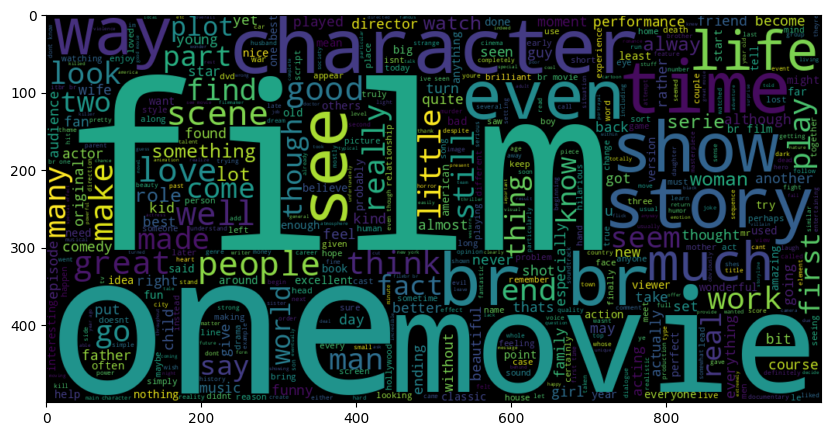

In [ ]:
# Wordcloud for Positive Reviews
plt.figure(figsize=(10,10))
positive_text=" ".join(df.loc[df["label"] == 1]['Cleaned_Review'])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

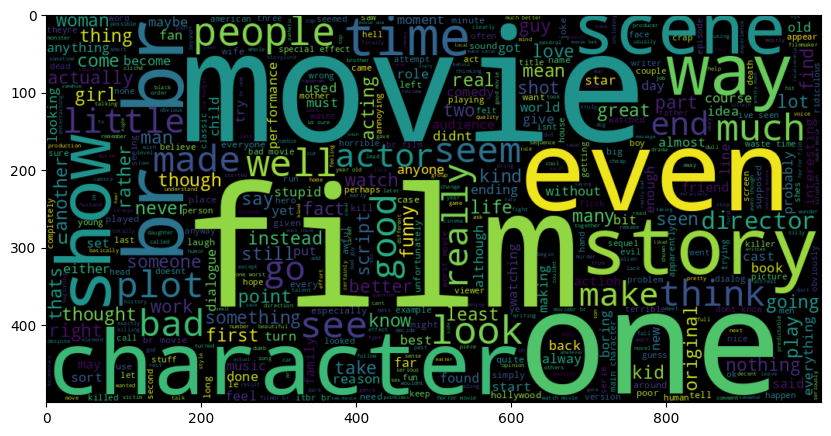

In [ ]:
# Wordcloud for Negative Reviews
plt.figure(figsize=(10,10))
negative_text=" ".join(df.loc[df["label"] == 0]['Cleaned_Review'])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/dataset/professor_reviews.csv')
df2 = pd.DataFrame(df2)

df2.dropna(inplace=True)
df2.columns

# df3 = df2.drop('1', axis=1)

Index(['review', 'sentiment'], dtype='object')

In [ ]:
df2.shape

(50000, 2)

In [ ]:
df2.drop(df.index[:20000], inplace=True)

In [ ]:
# df2['Useful'] = df2['Useful'].astype(int)
df3 = df2

In [ ]:
def predict_sentiment_bin(sentence, model, tfidf_vectorizer):
    cleaned_sentence = dataPreparation(sentence) # clear sentence
    sentence_vectorized = tfidf_vectorizer.transform([cleaned_sentence]).toarray() # vectorize the sentence
    prediction = model.predict(sentence_vectorized) # to predict with use model
    return 'positive' if prediction[0] == 1 else 'negative'

In [ ]:
df3['predicted'] = df3['review'].apply(predict_sentiment_bin, args=(model, tfidf_vectorizer,))
# df3['result'] = df3['1'] == df
df3['result'] = df3['sentiment'] == df3['predicted']
df3['result'].value_counts()

result
True     25701
False     4299
Name: count, dtype: int64

In [ ]:
p=df3.groupby('predicted').count()
p

,Review
predicted,
Negative,158
Positive,153


In [ ]:
model_pkl_file = "review_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate model
y_predict = model.predict(X_test_vectorized)

# check results
print(classification_report(y_test, y_predict, digits=4))

              precision    recall  f1-score   support

         0.0     0.8202    0.6952    0.7526       105
         1.0     0.7852    0.8797    0.8298       133

    accuracy                         0.7983       238
   macro avg     0.8027    0.7875    0.7912       238
weighted avg     0.8007    0.7983    0.7957       238

